# Extracting Features

In [4]:
import numpy as np
import networkx as nx
# Load the adjacency matrix into a numpy array.
normal_mat = np.loadtxt('../Normal.txt', dtype=int)
for i in range(0,70):
        normal_mat[i][i] = 0
G_Normal = nx.from_numpy_matrix(normal_mat)
print("Number Of Edges: ",len(G_Normal.edges()))
print("Number Of Nodes: ",len(G_Normal.nodes()))

Number Of Edges:  1490
Number Of Nodes:  70


In [5]:
# Load the adjacency matrix into a numpy array.
eMCI_mat = np.loadtxt('../eMCI.txt', dtype=int)
for i in range(0,70):
        eMCI_mat[i][i] = 0
G_eMCI = nx.from_numpy_matrix(eMCI_mat)
print("Number Of Edges: ",len(G_eMCI.edges()))
print("Number Of Nodes: ",len(G_eMCI.nodes()))

Number Of Edges:  1510
Number Of Nodes:  70


# Edge to Vector

In [6]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

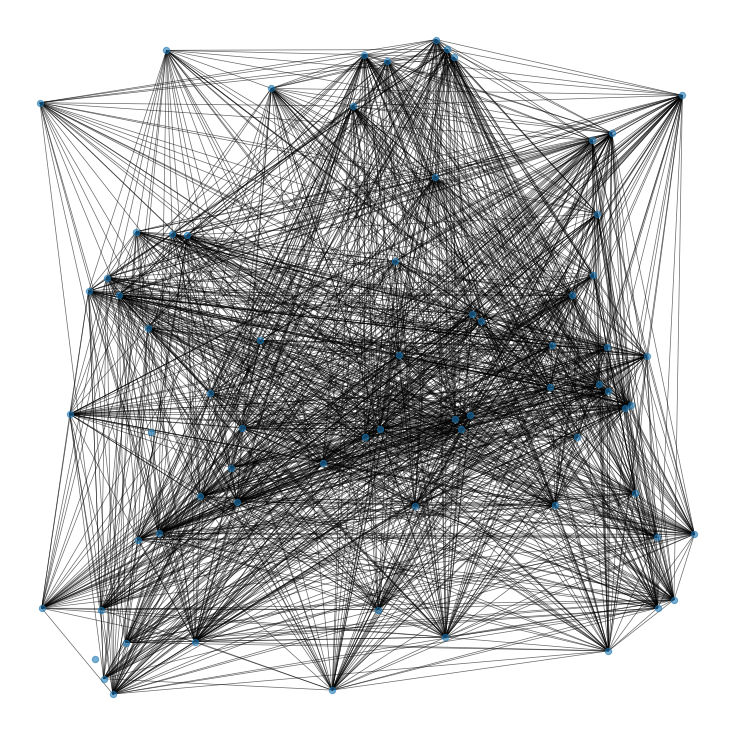

In [7]:
plt.figure(figsize=(10,10))
pos = nx.random_layout(G_eMCI, seed=23)
nx.draw(G_eMCI, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

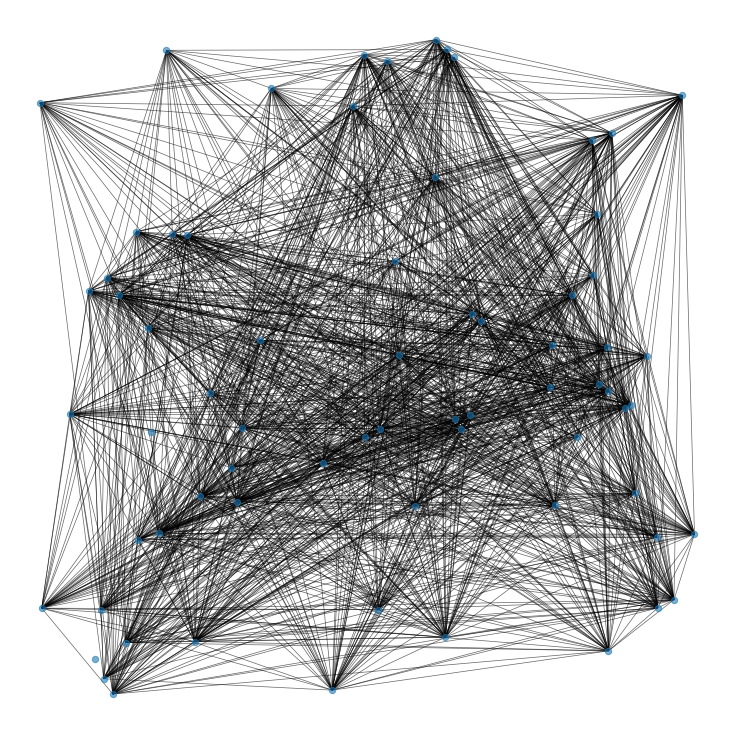

In [8]:
plt.figure(figsize=(10,10))
pos = nx.random_layout(G_Normal, seed=23)
nx.draw(G_Normal, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)
plt.show()

In [9]:
edges = list(G_Normal.edges)
node_list_1 = [item[0] for item in edges]
node_list_2 = [item[1] for item in edges]
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

In [10]:
fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [11]:
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

In [12]:
adj_G = nx.to_numpy_matrix(G,nodelist = node_list)

In [13]:
adj_G.shape

(68, 68)

In [14]:
nx.is_path(G, [0])

True

In [15]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if adj_G[i,j] == 0:
        all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 68/68 [00:00<00:00, 11220.01it/s]


In [16]:
len(all_unconnected_pairs)

788

In [17]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [18]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 1490/1490 [00:01<00:00, 858.48it/s] 


In [19]:
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link'
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)


In [20]:
data['link'].value_counts()

1    1423
0     788
Name: link, dtype: int64

In [21]:
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())


In [33]:
#from node2vec import Node2Vec

# Generate walks
#node2vc = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
#n2w_model = node2vc.fit(window=7, min_count=1)

In [34]:
!pip install node2vec 

  Using cached https://files.pythonhosted.org/packages/9b/cd/dc52755d30ba41c60243235460961fc28022e5b6731f16c268667625baea/networkx-2.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/55/85/70c6602b078bd9e6f3da4f467047e906525c355a4dacd4f71b97a35d9897/joblib-1.0.1-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/45/b2/6c7545bb7a38754d63048c7696804a0d947328125d81bf12beaa692c3ae3/numpy-1.19.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/4e/8c/f1035bd24b0e352ddba7be320abc1603fc4c9976fcda6971ed287be59164/tqdm-4.58.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/2b/e0/fa6326251692056dc880a64eb22117e03269906ba55a6864864d24ec8b4e/gensim-3.8.3-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/ed/1b/72a1821152d07cf1d8b6fce298aeb06a7eb90f4d6d41acec9861e7cc6df0/decorator-4.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/

In [23]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/68 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:01<00:00, 30.43it/s]


In [24]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [26]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

In [27]:
lr = LogisticRegression(class_weight="balanced")

lr.fit(xtrain, ytrain)

LogisticRegression(class_weight='balanced')

In [28]:
predictions = lr.predict_proba(xtest)

In [29]:
roc_auc_score(ytest, predictions[:,1])

0.6443501170960187

In [30]:
import lightgbm as lgbm

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
model = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)


ModuleNotFoundError: No module named 'lightgbm'

# Feature Vector With Edges

In [32]:
fb_df.head()

,node_1,node_2
0,0,1
1,0,2
2,0,4
3,0,5
4,0,6


In [34]:
for item in zip(fb_df['node_1'],fb_df['node_2']):
    print(item)

(0, 1)
(0, 2)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(0, 10)
(0, 11)
(0, 12)
(0, 13)
(0, 14)
(0, 15)
(0, 16)
(0, 17)
(0, 18)
(0, 19)
(0, 20)
(0, 21)
(0, 22)
(0, 23)
(0, 24)
(0, 26)
(0, 27)
(0, 28)
(0, 29)
(0, 30)
(0, 32)
(0, 33)
(0, 34)
(0, 44)
(0, 47)
(0, 51)
(0, 57)
(0, 59)
(0, 63)
(1, 2)
(1, 4)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(1, 10)
(1, 11)
(1, 12)
(1, 13)
(1, 14)
(1, 15)
(1, 16)
(1, 17)
(1, 18)
(1, 19)
(1, 20)
(1, 21)
(1, 22)
(1, 23)
(1, 24)
(1, 25)
(1, 26)
(1, 27)
(1, 28)
(1, 29)
(1, 30)
(1, 31)
(1, 33)
(1, 34)
(1, 36)
(1, 37)
(1, 39)
(1, 44)
(1, 46)
(1, 47)
(1, 48)
(1, 51)
(1, 52)
(1, 54)
(1, 57)
(1, 58)
(1, 59)
(1, 60)
(1, 61)
(1, 62)
(1, 66)
(1, 69)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(2, 10)
(2, 11)
(2, 12)
(2, 13)
(2, 14)
(2, 15)
(2, 16)
(2, 17)
(2, 18)
(2, 19)
(2, 20)
(2, 21)
(2, 22)
(2, 23)
(2, 24)
(2, 25)
(2, 26)
(2, 27)
(2, 28)
(2, 29)
(2, 30)
(2, 31)
(2, 33)
(2, 34)
(2, 36)
(2, 37)
(2, 44)
(2, 46)
(2, 48)
(2, 50)
(2, 51)
(2, 52)
(2, 56)
(2, 57)
(2, 58)
(2, 59)
(2, 

In [ ]:
def _featureVector(Graph,fb_df):
    for item in zip(fb_df['node_1'],fb_df['node_2']):
        
    
        
    
    
    